In [ ]:
pip install wordcloud --user

In [ ]:
pip install seaborn --user

In [1]:
# Load and preprocess the dataset
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler

import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv('sentlex_exp12.txt',skiprows=1, names=['ReviewID', 'Review'])
df.head()

,ReviewID,Review
0,1,'
1,2,' (
2,3,' ( the cockettes
3,4,' ( the cockettes )
4,5,' ( the cockettes ) provides a window into a s...


In [3]:
# Preprocess the data
# Remove punctuation
df['Review'] = df['Review'].str.replace('[^\w\s]','')

In [4]:
# Convert to lowercase
df['Review'] = df['Review'].str.lower()

In [5]:
#Lemmmatize all the words to base form.
wnl = WordNetLemmatizer()

def lemmatize_words(text):
    words = text.split()
    words = [wnl.lemmatize(word,pos='v') for word in words]
    return ' '.join(words)

df['Review'] = df['Review'].apply(lemmatize_words)

In [6]:
# Tokenize the reviews
df['Review'] = df['Review'].apply(word_tokenize)

In [7]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
punctuation=set(['movie','film'])
unnecessary = stop_words.union(punctuation)
df['Review'] = df['Review'].apply(lambda x: [word for word in x if word not in unnecessary])

In [8]:
# Utilize clustering techniques
# Vectorize the reviews
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Review'].apply(lambda x: ' '.join(x)))

Look for correct cluster count using silhouette score and TSNE

In [ ]:
# Utilize clustering techniques
# Vectorize the reviews
c_vectorizer = CountVectorizer()
X1 = c_vectorizer.fit_transform(df['Review'].apply(lambda x: ' '.join(x)))

In [ ]:
# initialized reducers with dimensions
n_comp = 5
lsa_tfidf = TruncatedSVD(n_components=n_comp)
lsa_cv = TruncatedSVD(n_components=n_comp)
nmf_tfidf = NMF(n_components=n_comp)
nmf_cv = NMF(n_components=n_comp)

# transformed my vectorizers data using reducers
lsa_tfidf_data = lsa_tfidf.fit_transform(X)
lsa_cv_data = lsa_cv.fit_transform(X1)
nmf_tfidf_data = nmf_tfidf.fit_transform(X)
nmf_cv_data = nmf_cv.fit_transform(X1)

In [ ]:
# initialize standardscaler
SS = StandardScaler()

# transform my reducer data using standardscaler
lsa_tfidf_data_scaled = SS.fit_transform(lsa_tfidf_data)
lsa_cv_data_scaled = SS.fit_transform(lsa_cv_data)
nmf_tfidf_data_scaled = SS.fit_transform(nmf_tfidf_data)
nmf_cv_data_scaled = SS.fit_transform(nmf_cv_data)

In [ ]:
#Find cluster count with best Silhouette score
SSEs = []
Sil_coefs = []
for k in range(3,8):
    print(k, datetime.now().strftime("%H:%M:%S"))
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(lsa_tfidf_data_scaled)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(lsa_tfidf_data_scaled, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 

In [ ]:
#Plot the Silhouette score
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(3,8)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('# clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

In [ ]:
# Clustering using the optimal cluster count
k = 6
kmeans = KMeans(n_clusters=k, random_state=1)
kmeans.fit(lsa_tfidf_data_scaled)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vectorizer.get_feature_names()

for i in range(0,k):
    word_list=[]
    print("cluster%d:"% i)
    for j in centers[i,:15]:
        word_list.append(terms[j])
    print(word_list) 

In [ ]:
#plot TSNE graph
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)
X_ne = tsne.fit_transform(lsa_tfidf_data_scaled[3000:])

figsize=(20,15)
plt.figure(dpi=300)
sns.scatterplot(data=X_ne, x=X_ne[:, 0], y=X_ne[:, 1], 
                hue=kmeans.labels_[3000:], alpha=0.5, size = 0.2, 
                palette='rainbow', legend='full');

Apply KMeans clustering and analyze results

In [9]:
# Apply K-Means clustering
clusters = 6
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(X)

In [10]:
# Extract meaningful insights
# Get the top words for each cluster
cluster_words=[]
for i in range(clusters):
    words=[vectorizer.get_feature_names()[ind] for ind in kmeans.cluster_centers_[i].argsort()[-12:]]
    cluster_words.append(words)

In [11]:
np.unique(kmeans.labels_,return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([ 11722, 176709,  38230,   5871,   4490,   2209], dtype=int64))

In [12]:
df['Cluster'] = kmeans.labels_

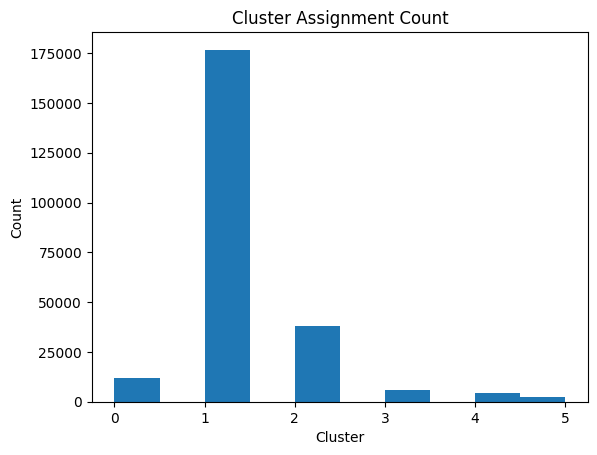

In [17]:
#Check for assigned cluster distribution. 
plt.title('Cluster Assignment Count')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.hist(df['Cluster'])
plt.show()

In [14]:
# Create a dataframe to store the results
results_df = pd.DataFrame(cluster_words, columns=['word_1', 'word_2', 'word_3', 'word_4', 'word_5', 'word_6', 'word_7', 'word_8', 'word_9', 'word_10', 'word_11', 'word_12'])

In [15]:
results_df.head(6)

,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,word_11,word_12
0,enough,feel,look,us,love,interest,44,good,story,character,time,make
1,way,9696,go,life,44,96,much,get,comedy,work,see,like
2,work,see,comedy,love,even,story,time,good,funny,like,character,44
3,go,really,like,care,make,know,see,much,wo,44,ca,nt
4,time,man,good,thing,like,make,best,movies,year,another,44,one
5,love,wit,time,bite,precious,offer,else,much,story,stuart,44,little


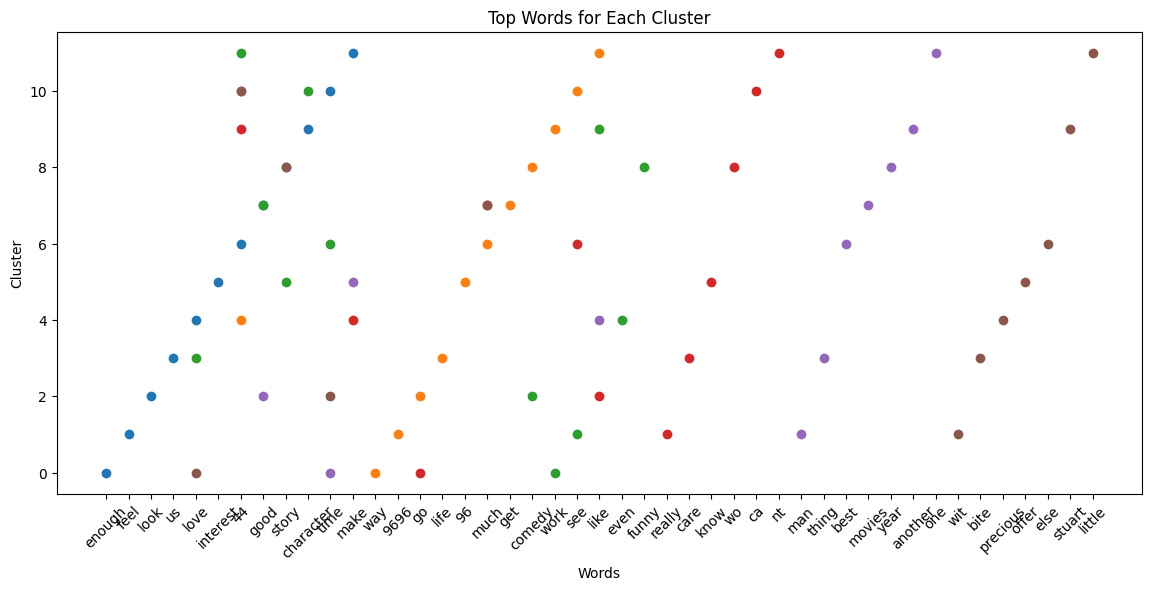

In [16]:
# Visualize the results. It seem many same words are found in multiple clusters. 
# Need to work on stop words and tune clustering algorithm parameters
plt.figure(figsize=(14,6))
for i in range(clusters):
    plt.scatter(results_df.iloc[i,:], range(12))
plt.title('Top Words for Each Cluster')
plt.xlabel('Words')
plt.ylabel('Cluster')
plt.xticks(rotation = 45)
plt.show()